In [15]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt


class LawnmowerEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, max_steps=100):
        # Define the observation and action spaces
        self.observation_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)

        # Initialize the grid
        self.grid = np.array([[6, 5, 6, 5],
                              [-5, -6,  -5, 6],
                              [-5,  -6, -6,  6],
                              [-6, -5,  -6, 6]])

        # Initialize the agent and goal positions
        self.agent_pos = np.array([0, 0])
        self.goal_pos = np.array([3, 3])

        # Initialize the reward
        self.reward = 0
        # self.history = []
        self.max_steps = max_steps
        self.current_step = 0

    def reset(self):

        self.current_step = 0
        if np.array_equal(self.agent_pos, self.goal_pos):
            self.agent_pos = np.array([0, 0])

        # Reset the agent position and reward
        self.agent_pos = np.array([0, 0])
        self.reward = 0

        # Return the initial observation
        return self._get_observation()

    def step(self, action):

        self.current_step += 1
        if self.current_step >= self.max_steps:
            done = True
        # Move the agent based on the chosen action
        if action == 0:
            self.agent_pos[0] -= 1  # Up
        elif action == 1:
            self.agent_pos[0] += 1  # Down
        elif action == 2:
            self.agent_pos[1] += 1  # Right
        elif action == 3:
            self.agent_pos[1] -= 1  # Left

        # Keep the agent within the grid boundaries
        self.agent_pos = np.clip(self.agent_pos, 0, 3)

        # Calculate the reward based on the new agent position
        self.reward = self.grid[tuple(self.agent_pos)]
        # self.history.append({"observation": self._get_observation(), "reward": self.reward, "done": done})
        # Check if the episode is done
        # self.reward > 0
        done = bool(np.array_equal(
            self.agent_pos, self.goal_pos))

        # self.history.append({"observation": self._get_observation(), "reward": self.reward, "done": done})
        # Return the new observation, reward, done flag, and info dictionary
        return self._get_observation(), self.reward, done, {}

    def render(self, mode='human'):
        # Create a new figure
        fig, ax = plt.subplots()

        # Plot the grid with markers for different tile types
        for i in range(4):
            for j in range(4):
                if self.grid[i][j] < 0:
                    ax.scatter(j, i, marker='X', color='r', s=1000)
                elif self.grid[i][j] == 0:
                    ax.scatter(j, i, marker='o', color='b', s=1000)
                elif self.grid[i][j] > 0:
                    ax.scatter(j, i, marker='o', color='g', s=1000)

        # Plot the agent and goal positions
        ax.scatter(self.agent_pos[1], 3 - self.agent_pos[0],
                   marker='s', color='y', s=1000)
        ax.scatter(self.goal_pos[1], 3 - self.goal_pos[0],
                   marker='s', color='m', s=1000)

        # Set the x and y axis limits
        ax.set_xlim([-0.5, 3.5])
        ax.set_ylim([-0.5, 3.5])

        # Add title and axis labels
        ax.set_title('Lawnmower Environment')
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')

        # Add gridlines
        ax.grid(which='major', color='gray', linestyle='-', linewidth=2)
        ax.set_xticks(np.arange(-0.5, 4, 1))
        ax.set_yticks(np.arange(-0.5, 4, 1))
        ax.xaxis.tick_top()
        
        # Flip the y-axis
        ax.invert_yaxis()
        
        # Show the plot
        plt.show()

    def _get_observation(self):
        # Convert the agent position to an observation index
        return np.ravel_multi_index(tuple(self.agent_pos), (4, 4))


env = LawnmowerEnv()
# Parameters
epsilon = 0.9
total_episodes = 100
max_steps = 100
alpha = 0.05
gamma = 0.95

# Initializing the Q-vaue
Q = np.zeros((env.observation_space.n, env.action_space.n))

# Function to choose the next action with episolon greedy


def choose_action(state):
    action = 0
    if np.random.uniform(0, 1) < epsilon:
        action = env.action_space.sample()
    else:
        action = np.argmax(Q[state, :])
    return action


# Initializing the reward
reward = 0

# Starting the SARSA learning
for episode in range(total_episodes):
    t = 0
    state1 = env.reset()
    action1 = choose_action(state1)

    while t < max_steps:
        # Visualizing the training
        # env.render()

        # Getting the next state
        state2, reward, done, info = env.step(action1)

        # Choosing the next action
        action2 = choose_action(state2)

        # Learning the Q-value
        Q[state1, action1] = Q[state1, action1] + alpha * \
            (reward + gamma * Q[state2, action2] - Q[state1, action1])

        state1 = state2
        action1 = action2

        # Updating the respective vaLues
        t += 1
        reward += 1

        # If at the end of learning process
        if done:
            break

# Evaluating the performance
print("Performace : ", reward/total_episodes)

# Visualizing the Q-matrix
print(Q)


Performace :  0.07
[[ 18.89029208  -3.6085793   17.27717041  17.88501835]
 [ 19.83796024  -2.89584618  18.90975058  19.13458146]
 [ 16.87361971  -0.62269027  20.57281287  16.28730666]
 [ 20.74398922  14.95112752  20.3746081   17.86371278]
 [ 18.15050306 -11.61328325  -1.6246801   -3.82265788]
 [ 16.140133   -11.56020703   2.35985593  -2.45191533]
 [ 17.36575757  -4.46758036  13.58958975  -3.49331497]
 [ 19.30066579  10.38096914  15.7122189   -1.01829811]
 [ -3.61781259 -12.53593162 -10.74480283 -11.15711231]
 [ -3.79216524 -11.37102997  -6.44429945  -9.30194816]
 [ -1.20805137  -5.75954583  10.13910995  -8.35723384]
 [ 13.44737542   5.14562555   8.57176586  -5.51402151]
 [ -9.17591781 -11.51565158 -10.89650701 -11.0033881 ]
 [-10.181691   -11.0191766   -7.0657204  -11.53344487]
 [ -4.5110376   -5.4993548    5.26748071  -8.58858743]
 [  0.           0.           0.           0.        ]]


# Updated For Part 2.2

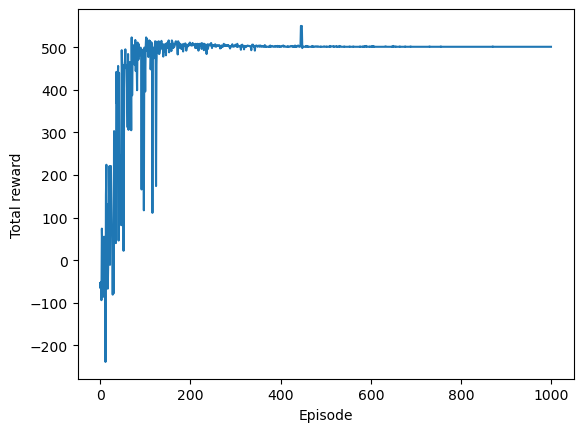

In [16]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt


class LawnmowerEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, max_steps=100):
        # Define the observation and action spaces
        self.observation_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)

        # Initialize the grid
        self.grid = np.array([[6, 5, 6, 5],
                              [-5, -6,  -5, 6],
                              [-5,  -6, -6,  6],
                              [-6, -5,  -6, 6]])

        # Initialize the agent and goal positions
        self.agent_pos = np.array([0, 0])
        self.goal_pos = np.array([3, 3])

        # Initialize the reward
        self.reward = 0
        # self.history = []
        self.max_steps = max_steps
        self.current_step = 0

    def reset(self):

        self.current_step = 0
        if np.array_equal(self.agent_pos, self.goal_pos):
            self.agent_pos = np.array([0, 0])

        # Reset the agent position and reward
        self.agent_pos = np.array([0, 0])
        self.reward = 0

        # Return the initial observation
        return self._get_observation()

    def step(self, action):

        self.current_step += 1
        if self.current_step >= self.max_steps:
            done = True
        # Move the agent based on the chosen action
        if action == 0:
            self.agent_pos[0] -= 1  # Up
        elif action == 1:
            self.agent_pos[0] += 1  # Down
        elif action == 2:
            self.agent_pos[1] += 1  # Right
        elif action == 3:
            self.agent_pos[1] -= 1  # Left

        # Keep the agent within the grid boundaries
        self.agent_pos = np.clip(self.agent_pos, 0, 3)

        # Calculate the reward based on the new agent position
        self.reward = self.grid[tuple(self.agent_pos)]
        # self.history.append({"observation": self._get_observation(), "reward": self.reward, "done": done})
        # Check if the episode is done
        # self.reward > 0
        done = bool(np.array_equal(
            self.agent_pos, self.goal_pos))

        # self.history.append({"observation": self._get_observation(), "reward": self.reward, "done": done})
        # Return the new observation, reward, done flag, and info dictionary
        return self._get_observation(), self.reward, done, {}

    def render(self, mode='human'):
        # Create a new figure
        fig, ax = plt.subplots()

        # Plot the grid with markers for different tile types
        for i in range(4):
            for j in range(4):
                if self.grid[i][j] < 0:
                    ax.scatter(j, i, marker='X', color='r', s=1000)
                elif self.grid[i][j] == 0:
                    ax.scatter(j, i, marker='o', color='b', s=1000)
                elif self.grid[i][j] > 0:
                    ax.scatter(j, i, marker='o', color='g', s=1000)

        # Plot the agent and goal positions
        ax.scatter(self.agent_pos[1], 3 - self.agent_pos[0],
                   marker='s', color='y', s=1000)
        ax.scatter(self.goal_pos[1], 3 - self.goal_pos[0],
                   marker='s', color='m', s=1000)

        # Set the x and y axis limits
        ax.set_xlim([-0.5, 3.5])
        ax.set_ylim([-0.5, 3.5])

        # Add title and axis labels
        ax.set_title('Lawnmower Environment')
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')

        # Add gridlines
        ax.grid(which='major', color='gray', linestyle='-', linewidth=2)
        ax.set_xticks(np.arange(-0.5, 4, 1))
        ax.set_yticks(np.arange(-0.5, 4, 1))
        ax.xaxis.tick_top()

        # Show the plot
        plt.show()

    def _get_observation(self):
        # Convert the agent position to an observation index
        return np.ravel_multi_index(tuple(self.agent_pos), (4, 4))


env = LawnmowerEnv()

# Set hyperparameters
alpha = 0.1  # step size
gamma = 0.99  # discount factor
epsilon = 1.0  # exploration rate
epsilon_decay_rate = 0.99
max_episodes = 1000
max_steps_per_episode = 100

# Initialize the Q-value table with arbitrary values
Q = np.zeros((env.observation_space.n, env.action_space.n))

# Define the epsilon-greedy policy


def epsilon_greedy_policy(state, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        # Explore
        return env.action_space.sample()
    else:
        # Exploit
        return np.argmax(Q[state, :])


# Train the agent using SARSA
reward_history = []
for episode in range(max_episodes):
    state = env.reset()
    action = epsilon_greedy_policy(state, epsilon)
    done = False
    total_reward = 0

    for step in range(max_steps_per_episode):
        next_state, reward, done, _ = env.step(action)
        next_action = epsilon_greedy_policy(next_state, epsilon)
        Q[state, action] += alpha * \
            (reward + gamma * Q[next_state, next_action] - Q[state, action])
        state = next_state
        action = next_action
        total_reward += reward
        if done:
            break

    # Decay the exploration rate for the next episode
    epsilon *= epsilon_decay_rate
    reward_history.append(total_reward)

env.close()

# Plot the reward history

plt.plot(reward_history)
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()


In [17]:
alphas = [0.1, 0.2, 0.3]
gammas = [0.9, 0.95, 0.99]
epsilon_decay_rates = [0.9, 0.95, 0.99]

best_reward = float('-inf')
best_hyperparams = None

for alpha in alphas:
    for gamma in gammas:
        for epsilon_decay_rate in epsilon_decay_rates:
            # Train the agent using SARSA
            Q = np.zeros((env.observation_space.n, env.action_space.n))
            epsilon = 1.0
            reward_history = []
            for episode in range(max_episodes):
                state = env.reset()
                action = epsilon_greedy_policy(state, epsilon)
                done = False
                total_reward = 0
                while not done:
                    next_state, reward, done, _ = env.step(action)
                    next_action = epsilon_greedy_policy(next_state, epsilon)
                    # Update Q-values using SARSA
                    Q[state][action] = Q[state][action] + alpha * \
                        (reward + gamma * Q[next_state]
                         [next_action] - Q[state][action])
                    state = next_state
                    action = next_action
                    total_reward += reward
                    # Decay epsilon
                    epsilon *= epsilon_decay_rate
                    # Append the total reward for this episode to the reward history
                    reward_history.append(total_reward)
                    # Find the average reward over the last 100 episodes
                    avg_reward = np.mean(reward_history[-100:])
                    # Check if this is the best set of hyperparameters so far
                    if avg_reward > best_reward:
                        best_reward = avg_reward
                        best_hyperparams = (alpha, gamma, epsilon_decay_rate)

                print(
                    f"Best hyperparameters: alpha={best_hyperparams[0]}, gamma={best_hyperparams[1]}, epsilon_decay_rate={best_hyperparams[2]}")
                print(
                    f"Best average reward over last 100 episodes: {best_reward}")


KeyboardInterrupt: 